# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
scaler_id = "lowmass_scan"

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD"
path_to_compiled_data = f"{working_dir}/compiled_data/{project_id}"
    
    
run_jet = False
if run_jet:
    codes_list = ["DATA_jet"]
    sim_id = "DATA_jet" # should probably rename this to data_id
else:
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet" # should probably rename this to data_id
signal_id = ""

    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

DATA_nojet opp sign (21803678,)
DATA_nojet same sign (6756613,)


## Visualize the data

In [4]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

#hist_all_features_dict([uncut_data[codes_list[0]]], codes_list, feature_set, kwargs_dict_dtype, nice_labels=True)
    


['mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

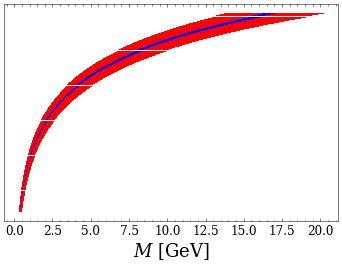

In [10]:
# define SB / SR choices

detector_resolution = 0.01
start_mass = 0.3

current_mass = start_mass
all_bins = [start_mass]


while current_mass < 20:
    loc_bin_width = current_mass*detector_resolution
    current_mass += loc_bin_width
    all_bins.append(current_mass)
    

num_bins_total = len(all_bins)

SB_num_bins = 17
SR_num_bins = 5
window_gap = 2
window_length = 2*SB_num_bins + SR_num_bins



bin_edge_definitions = {bin_i:{"SBL":[],"SR":[], "SBH":[]} for bin_i in range(num_bins_total)}
    
plt.figure()

for i in range(0, num_bins_total, window_gap):
    if i + window_length < num_bins_total:
        
        bin_edge_definitions[i]["SBL"] = all_bins[i:i+SB_num_bins+1]
        bin_edge_definitions[i]["SR"] = all_bins[i+SB_num_bins:i+SB_num_bins+SR_num_bins+1]
        bin_edge_definitions[i]["SBH"] = all_bins[i+SB_num_bins+SR_num_bins:i+2*SB_num_bins+SR_num_bins+1]
        
        plt.plot(bin_edge_definitions[i]["SBL"], [i for x in bin_edge_definitions[i]["SBL"]], color = "red")
        plt.plot(bin_edge_definitions[i]["SR"], [i for x in bin_edge_definitions[i]["SR"]], color = "blue")
        plt.plot(bin_edge_definitions[i]["SBH"], [i for x in bin_edge_definitions[i]["SBH"]], color = "red")
        

plt.xlabel("$M$ [GeV]")
plt.yticks([])
plt.show()
    
   
with open(f"{working_dir}/projects/{scaler_id}/processed_data/bin_edge_definitions", "wb") as ofile:
    pickle.dump(bin_definitions, ofile)



In [ ]:
cut_data, cut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    # define cuts to reduce the starting significance
    pass_indices = (uncut_data[code]["dimu_pt"] >= -1)
    pass_indices_samesign = (uncut_data_samesign[code]["dimu_pt"] >= -1)
        
    
    # apply cuts to oppsign
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    # apply cuts to samesign
    for feat in feature_set:
        cut_data_samesign[code][feat] = uncut_data_samesign[code][feat][pass_indices_samesign]
    
    print(f"{code} oppsign has shape {cut_data[code][feat].shape} after cuts")
    print(f"{code} samesign has shape {cut_data_samesign[code][feat].shape} after cuts")
    
    
#hist_all_features_dict([cut_data["DATA_nojet"]], ["DATA_nojet"], feature_set, kwargs_dict_dtype, nice_labels=True)


Check how local cuts affect the starting significance

In [ ]:
index = 2

loc_SB_left = bin_definitions["SB_left"][index]
loc_SB_right = bin_definitions["SB_right"][index]
loc_SR_left = bin_definitions["SR_left"][index]
loc_SR_right = bin_definitions["SR_right"][index]

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(loc_SR_left, loc_SR_right, loc_SB_left, loc_SB_right, num_bins_SR= 6)


plt.figure(figsize = (7,5))

x = np.linspace(loc_SB_left, loc_SB_right, 100) # plot curve fit

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= loc_SB_left) & (cut_data[code]["dimu_mass"] <= loc_SB_right)]
masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= loc_SB_left) & (cut_data_samesign[code]["dimu_mass"] <= loc_SB_right)]


plt.hist(masses_with_bounds, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"OS")
plt.hist(masses_with_bounds_samesign, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"SS")


plt.axvline(loc_SR_left)
plt.axvline(loc_SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

#plt.yscale("log")

plt.show()

 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [ ]:
from sklearn.preprocessing import StandardScaler


bands = ["SBL", "SR", "SBH"]
N_total_events = 0
N_total_events_samesign = 0

for i in range(len(bin_definitions["SR_left"])):
    
    # define SR, SB

    loc_SB_left = bin_definitions["SB_left"][i]
    loc_SB_right = bin_definitions["SB_right"][i]
    loc_SR_left = bin_definitions["SR_left"][i]
    loc_SR_right = bin_definitions["SR_right"][i]
    
    print(f"SB bounds: {loc_SB_left}, {loc_SB_right}")
    print(f"SR bounds: {loc_SR_left}, {loc_SR_right}")

    band_bounds = {"SBL": [loc_SB_left, loc_SR_left],
                       "SR": [loc_SR_left, loc_SR_right],
                       "SBH": [loc_SR_right, loc_SB_right],
                               }
    
    # preprocess the data

    preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}

    for code in codes_list:
        for b in bands:

            # opp sign
            loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts[b][code] = {}
            for feat in feature_set:
                preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            N_total_events += preproc_dicts[b][code][feat].shape[0]

            # same sign
            loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts_samesign[b][code] = {}
            for feat in feature_set:
                preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
            N_total_events_samesign += preproc_dicts_samesign[b][code][feat].shape[0]

    print(f"Total events opp sign: {N_total_events}")
    print(f"Total events same sign: {N_total_events_samesign}")
    
    
    # transformed / preprocess data
    
    sizes_dict, sizes_dict_samesign = {}, {}

    proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}
    
    frac_events_save = 0.2

    for feat in feature_set: 

        # train the preprocessor on the opp sign data only
        data_SB = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)

        if feat == "dimu_mass": # don't logit transform
            mass_scaler = StandardScaler()
            mass_scaler = mass_scaler.fit(data_SB)

            with open(f"{working_dir}/projects/{scaler_id}/processed_data/mass_scaler_{i}", "wb") as ofile:
                pickle.dump(mass_scaler, ofile)
                
            num_events_save = int(len(preproc_dicts[b][sim_id][feat])*frac_events_save)

            for b in bands:
                proccessed_data_dict[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts[b][sim_id][feat][:num_events_save].reshape(-1,1))
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1,1))
                sizes_dict[b] = proccessed_data_dict[b]["s_inj_data"][feat].shape[0]
                sizes_dict_samesign[b] = proccessed_data_dict_samesign[b]["s_inj_data"][feat].shape[0]

        else: 
            data_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat], preproc_dicts["SR"][sim_id][feat])).reshape(-1, 1)
            all_min = np.min(data_all)
            all_max = np.max(data_all)
            # logit transform the features
            transformed_feats = logit_transform(data_SB, all_min, all_max)
            # subtract off mean, std of the training set
            mean_to_sub = np.mean(transformed_feats)
            std_to_sub = np.std(transformed_feats)
            
            num_events_save = int(len(preproc_dicts[b][sim_id][feat])*frac_events_save)

            for b in bands:
                proccessed_data_dict[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts[b][sim_id][feat][:num_events_save], all_min, all_max) - mean_to_sub)/std_to_sub
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_samesign[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub

    print(sizes_dict)
    print(sizes_dict_samesign)

    """
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{i}_nojet_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict, ofile)

    
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{i}_samesign_nojet_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_samesign, ofile)
    """

    print()


## Preprocessing

Standard scaling is fine

In [ ]:
hist_all_features_dict([proccessed_data_dict["SBL"]["s_inj_data"], proccessed_data_dict["SBH"]["s_inj_data"], proccessed_data_dict["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_samesign["SBL"]["s_inj_data"], proccessed_data_dict_samesign["SBH"]["s_inj_data"], proccessed_data_dict_samesign["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





Create a batch script for flow training


In [ ]:
feature_sets = workflow["feature_sets"]

if run_jet: jet_id = "jet"
else:jet_id = "nojet"

num_windows = len(bin_definitions["SB_left"])
    
    
    
batches_to_run = ["single_3"]

with open("batch_lowmass_scan_05.sh", "w") as ofile:
    
    ofile.write("#!/bin/sh \n\n")
    ofile.write("#SBATCH -N 1\n")
    ofile.write("#SBATCH -C gpu\n")
    ofile.write("#SBATCH -G 1\n")
    ofile.write("#SBATCH -q regular\n")
    ofile.write("#SBATCH --job-name=lowmass_scan\n")
    ofile.write("#SBATCH --mail-user=rmastand@berkeley.edu\n")
    ofile.write("#SBATCH --mail-type=ALL\n")
    ofile.write("#SBATCH -t 3:00:00\n")
    ofile.write("#SBATCH -A m3246\n")
    ofile.write(f"#SBATCH --array=0-{2*num_windows-1}\n\n")
    ofile.write(f"declare -a commands=(\n")

    i = 0

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = '[{i}]="python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = i, jet_id = jet_id )
            ofile.write(loc_command)
            ofile.write("\n")
            loc_command = '[{i}]="python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_samesign_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = 2*i+1, jet_id = jet_id )
            #ofile.write(loc_command)
            #ofile.write("\n")
            i += 1

    ofile.write(f")\n")
    ofile.write(f"srun ${{commands[$SLURM_ARRAY_TASK_ID]}}")



In [ ]:
with open("batch_lowmass_scan_06.sh", "w") as ofile:

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 06_eval_CATHODE.py -f {fs} -p {window_index} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 06_eval_CATHODE.py -f {fs} -p {window_index}_samesign -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")

In [ ]:
n_ensemble = 20
n_bootstrap = 1

with open("batch_lowmass_scan_07.sh", "w") as ofile:
    

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -train_samesign -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            #ofile.write(loc_command+"\n")
            

    ofile.write(f")\n")

